# Data Prep and Exploratory Analysis
* To succecfully run this notebook you need a python3.7 kernel with requirements in ./sagemaker-custom-image/requirements.txt

## This notebook will help you to do:
* Import raw data
* Feature Engineering
* Univariate Analysis
* Save final dataset with the selected features into S3 to train the model

In [4]:
try:
    import sys
    sys.path.append('/var/lang/lib/python37.zip')
    sys.path.append('/var/lang/lib/python3.7')
    sys.path.append('/var/lang/lib/python3.7/lib-dynload')
    sys.path.append('/var/lang/lib/python3.7/site-packages')
    sys.path.remove('/opt/.sagemakerinternal/conda/lib/python3.7/site-packages')
except:
    pass

# 1. Parameters

In [5]:
#Name
ModelName = 'user_segmentation_model'

#Setting the VarId and VarDate parameters
VarId = 'id'
VarDate = 'ReferenceDate'

#process outputs such as MOJO model, images and performance of tested models
OutputPath = './output_model/'

#If you have a huge dataset, I should consider use a small sample for first execution
PctSampleSize = 1

#ATTENTION: bucket name created in S3
bucket = 'now-app-media-service'

In [6]:
import json
import pandas as pd
import numpy as np
import boto3
import sweetviz as sv
from io import StringIO
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import awswrangler as wr
from sagemaker import get_execution_role
warnings.filterwarnings("ignore", category=FutureWarning)

# 2. Import raw data from Athena

In [7]:
#Create boto3 sesesion for Athena, SageMaker and S3 connection
my_boto3_session = boto3.Session(region_name='us-east-1')

In [8]:
query="""
select
     a.id
	,a.userid
	,a.viewedpercent
	,a.timesviewed
	,a.likedrecommendation
	,b.headline
	,b.posttext
	,b.tags
	,b.relevancescore
	,b.categorytitle
	,b.contributorlocationtitle
	,c.detaofbirth
from nowapp.views as a
	left join nowapp.posts as b 
        on a.id = b.id
	left join nowapp.users as c 
        on a.userId = c.id;
"""

In [9]:
dataprep_df_full = wr.athena.read_sql_query(query, database="nowapp", boto3_session=my_boto3_session).rename(columns={'userid': 'userId',
                   'viewedpercent' : 'viewedPercent',
                   'timesviewed': 'timesViewed',
                   'likedrecommendation' : 'likedRecommendation',
                   'posttext' : 'postText',
                   'relevancescore' : 'relevanceScore',
                   'categorytitle' : 'categoryTitle',
                   'contributorlocationtitle' : 'contributorLocationTitle',
                   'detaofbirth' : 'dateOfBirth'
                  })

In [10]:
dataprep_df_full.head()

,id,userId,viewedPercent,timesViewed,likedRecommendation,headline,postText,tags,relevanceScore,categoryTitle,contributorLocationTitle,dateOfBirth
0,a57f2c48-8538-4902-ace7-ba5cdf4454af,f72449ab-5afd-4658-81f8-9d5520b3789d,0.318541,3,yes,All everybody miss,All everybody miss. Safe herself result. Group...,"#music, #firearms",3,News,Nealstad,1993-11-20
1,6e95327f-2f6e-4b5f-a928-a07d8299876d,18bdb5a4-1eba-48e4-95b0-4c6a46737f8e,0.978273,1,yes,Ever scene office teach hear,Ever scene office teach hear. About speak able...,#celebrities,5,News,Nealstad,1976-04-06
2,9568da13-7bed-452a-a5a4-7943f708ca59,80aed78c-0379-432b-bfcf-08590c266670,0.259012,1,no,Sense low build until finally,Sense low build until finally. Even hotel even...,"#art, #family, #entertainment, #technology",11,News,Nealstad,1982-06-22
3,ba95bdc8-d6cf-46ad-91fb-df12fb56a320,5fc593cf-6995-4161-8d39-26e81acfff9e,0.261744,3,yes,Capital recent evening officer thought,Capital recent evening officer thought. Often ...,"#extremeweather, #crime, #breakingnews, #diet",25,News,Nealstad,1994-04-13
4,7fc96e06-9306-4822-983e-9fd754044b24,35b4192f-437a-4663-b78a-d8db0411e304,0.950285,2,no,Again couple education let among,Again couple education let among. Today exampl...,#diet,79,News,Nealstad,1988-03-20


In [11]:
random.seed(1)
for i in range(len(dataprep_df_full)):
    dataprep_df_full.loc[i, (VarDate)] = random.choice(['2022-01','2022-02','2022-03', '2022-04', '2022-05'])

In [12]:
#Work with a sample data if the PctSampleSize is less than 1
if PctSampleSize == 1:
    dataprep_df = dataprep_df_full.copy()
else:
    dataprep_df = dataprep_df_full.sample(frac=PctSampleSize, replace=False, random_state=1)

## 2.1 Define the data time period for used to traing de model

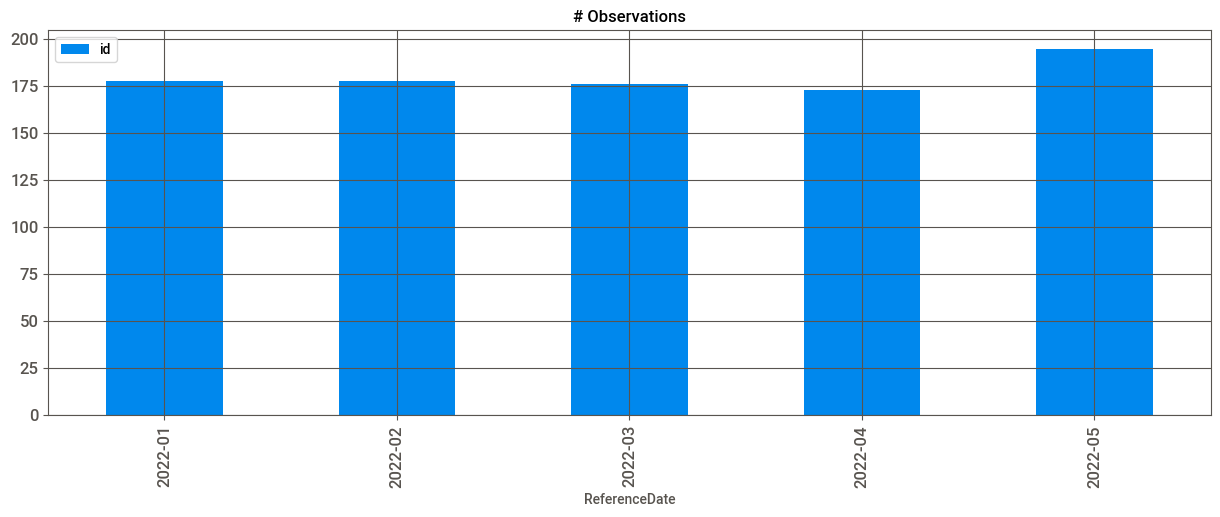

In [38]:
dataprep_target = dataprep_df[[VarDate, VarId]].groupby(VarDate).agg({VarId:'count'})
dataprep_target[VarId].plot(secondary_y=False, kind='bar', rot=90, figsize=(15,5), linewidth=2, fontsize=12, grid=True, legend=1, title=("# Observations"))

## 2.2 Separate the dataset into Traning and Test, ensuring the test dataset is an out of time sample

In [19]:
##Defined out of time validation (2022-05)
dataprep_df['dataset'] = ['train' if x <= '2022-04' else 'test' for x in dataprep_df[VarDate]]

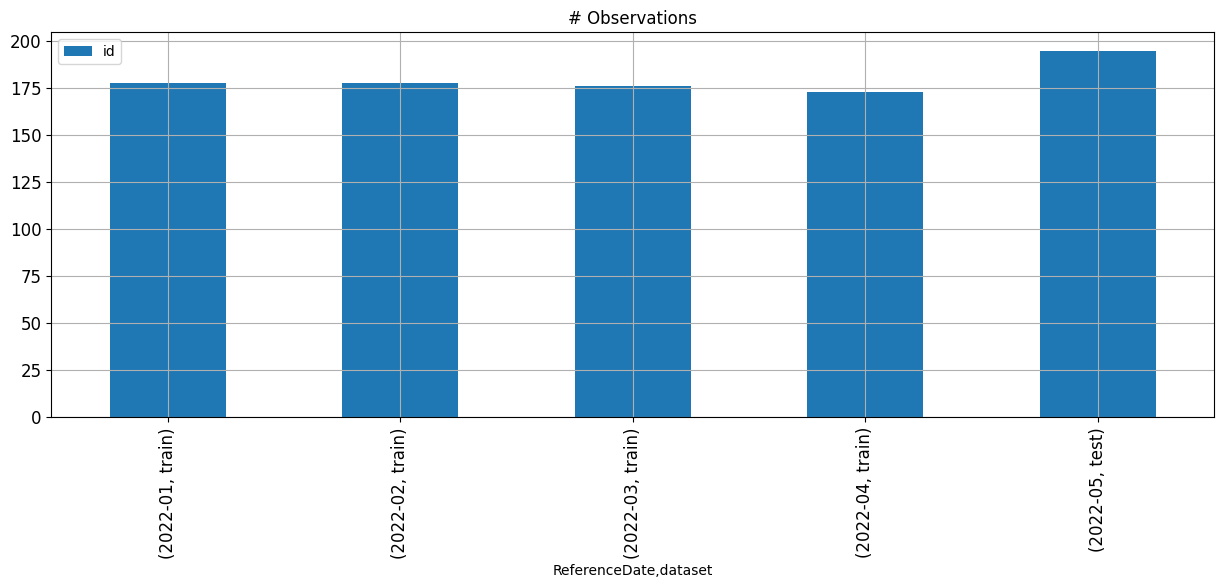

In [20]:
dataprep_target = dataprep_df[[VarDate, VarId, 'dataset']].groupby(by=[VarDate, 'dataset']).agg({VarId:'count'})
dataprep_target[VarId].plot(secondary_y=False, kind='bar', rot=90, figsize=(15,5), linewidth=2, fontsize=12, grid=True, legend=1, title=("# Observations"))

# 3. Feature Engineering

In [25]:
#Word count function for strings
def string_word_count(string):
    if pd.isna(string):
        return 0
    else:
        return len(string.split())
    
#Create the "Missing" category for missing values in string vaviables
dataprep_df = dataprep_df.apply(lambda x: x.fillna(np.nan) if x.dtype.kind in 'biufc' else x.fillna('Missing'))

#Rename columns to camelcase
dataprep_df = dataprep_df.rename(columns={'viewedPercent': 'percent_watched'})

#Calculate age based on data of birth
dataprep_df['age'] = dataprep_df['dateOfBirth'].apply(lambda x: (int((dt.date.today() - dt.datetime.strptime(x, '%Y-%m-%d').date()).days / 365.2425)))

#Count the number of words in the post headline
dataprep_df['headlineWordCount'] = dataprep_df.apply(lambda x: string_word_count(x['headline']), axis=1).astype(int)

#Count the number of words in the post description
dataprep_df['postTextWordCount'] = dataprep_df.apply(lambda x: string_word_count(x['postText']), axis=1).astype(int)

#Count the number of words in the post tags
dataprep_df['tagsWordCount'] = dataprep_df.apply(lambda x: string_word_count(x['tags']), axis=1).astype(int)

#Convert relevanceScore to int to avoid error in sweetviz
dataprep_df['relevanceScore']  = dataprep_df['relevanceScore'].astype(int)

## 3.1 Treatment of Numeric Missing Data

In [26]:
#Create the "Missing" category for missing values in string vaviables
dataprep_df = dataprep_df.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' else x.fillna('Missing'))

In [27]:
#Treatment of numeric columns
# dataprep_df['Age_Mean'] = dataprep_df['Age'].fillna(dataprep_df['Age'].mean())

# 4. Univariate Analysis

## 4.1 EDA with Sweetviz

                                             |          | [  0%]   00:00 -> (? left)


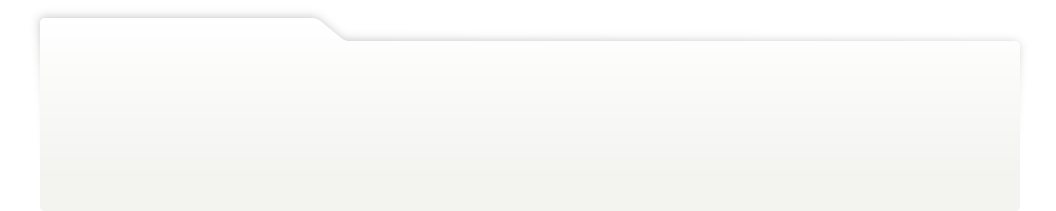
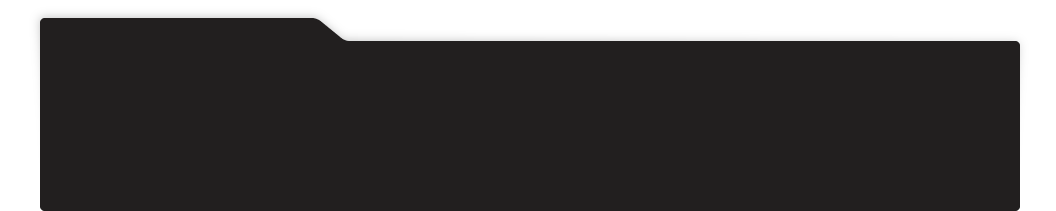
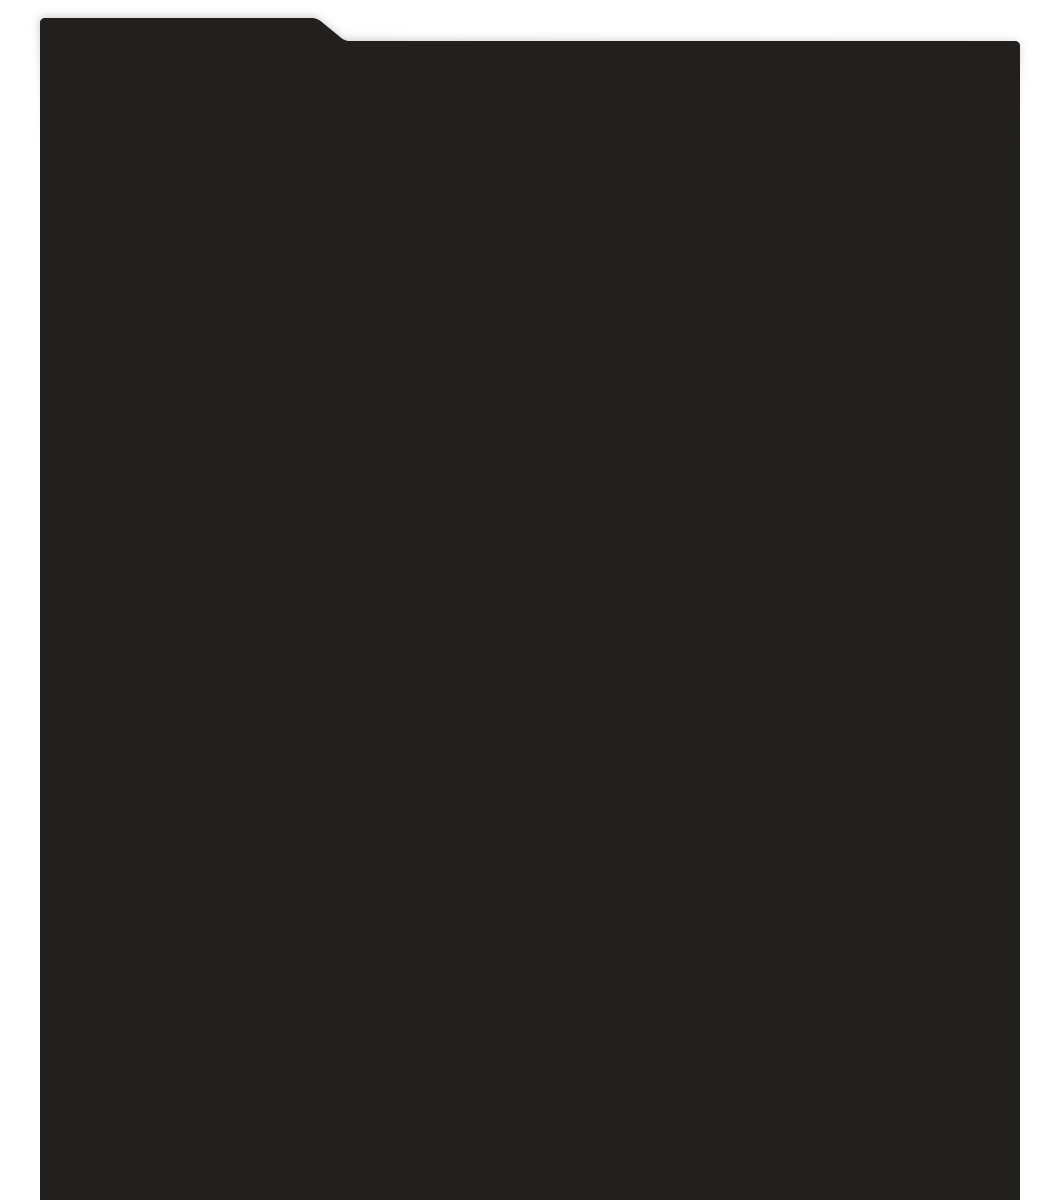
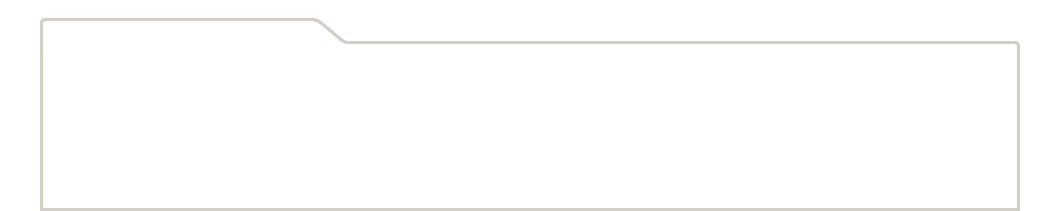
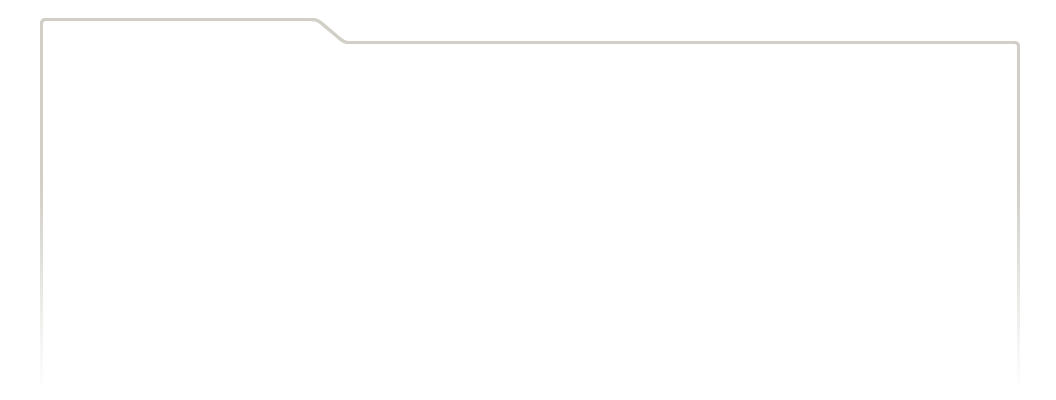
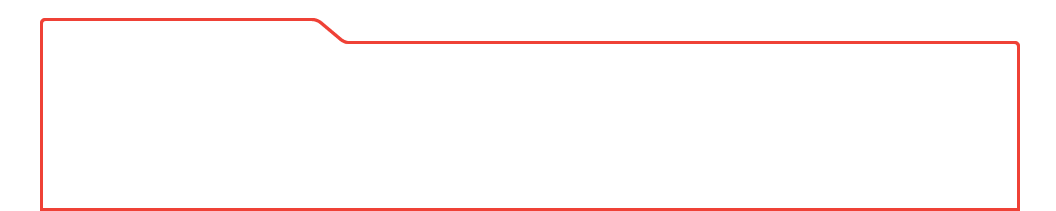
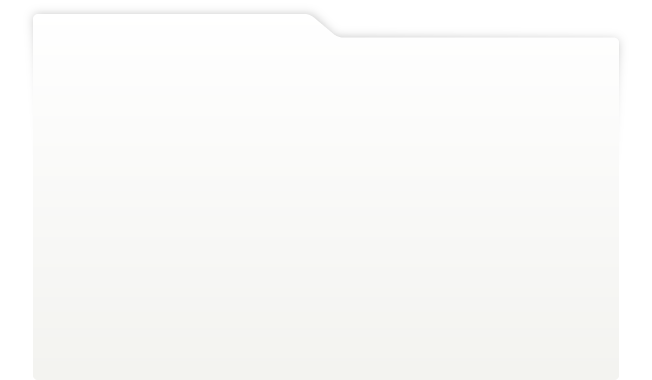
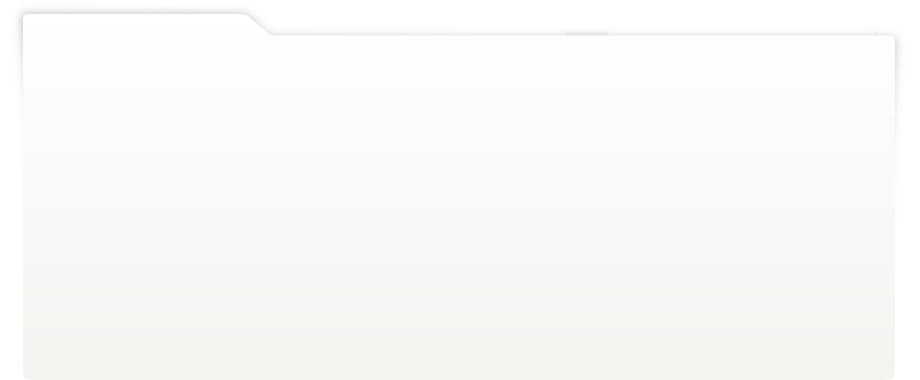
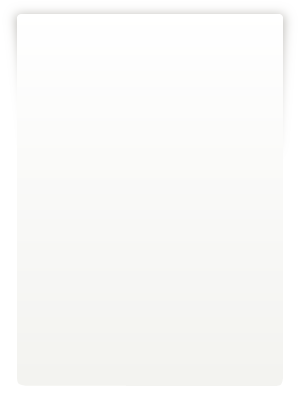
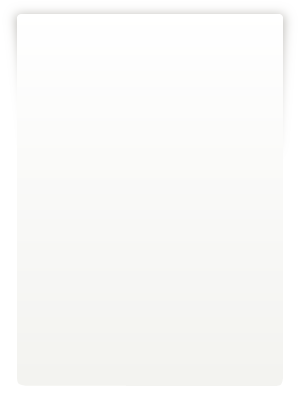
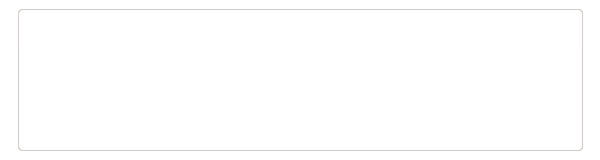
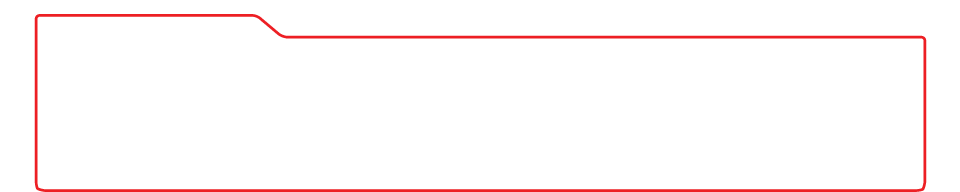
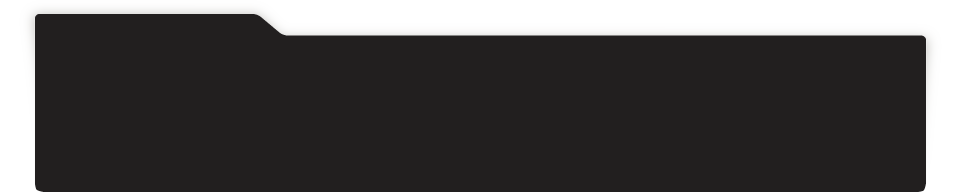
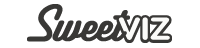
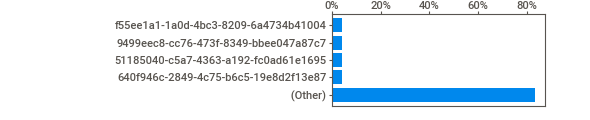
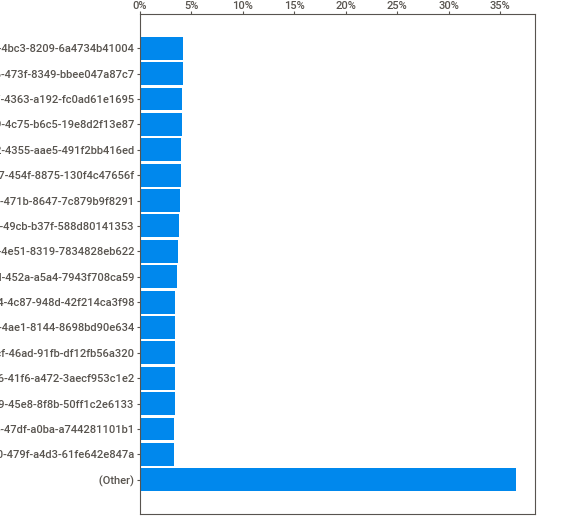
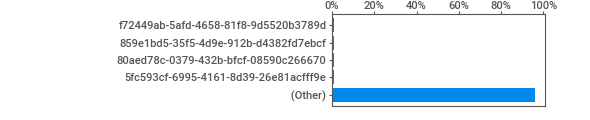
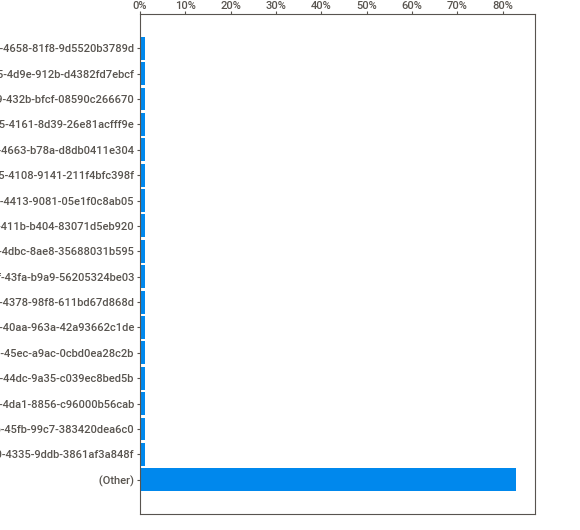
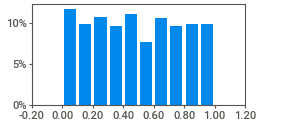
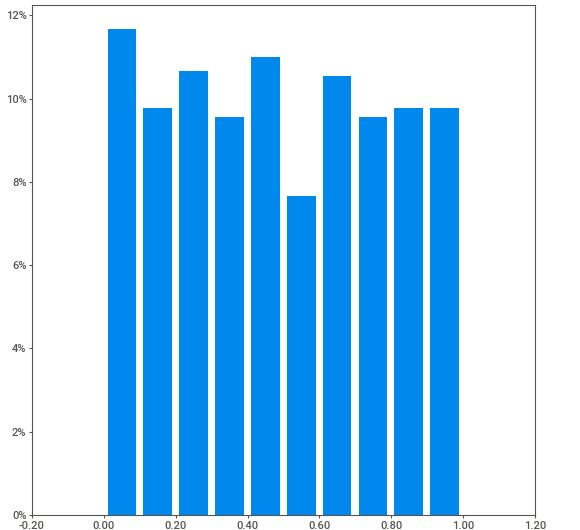
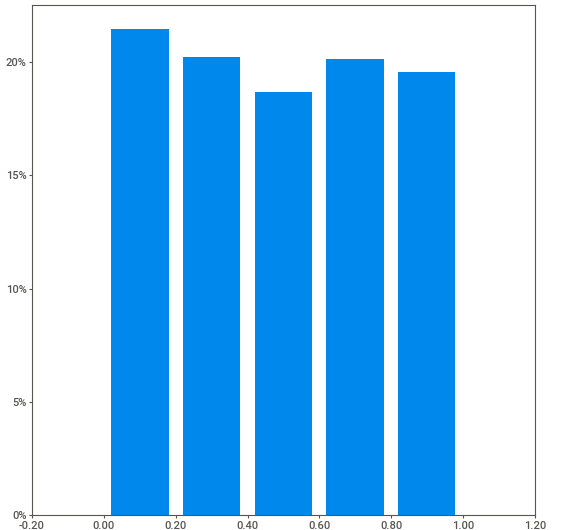
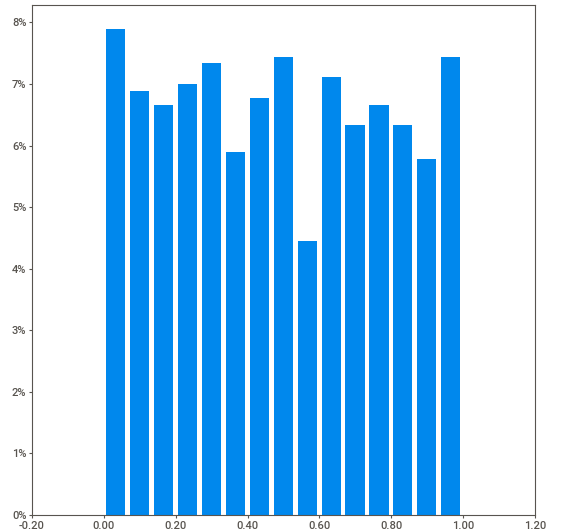
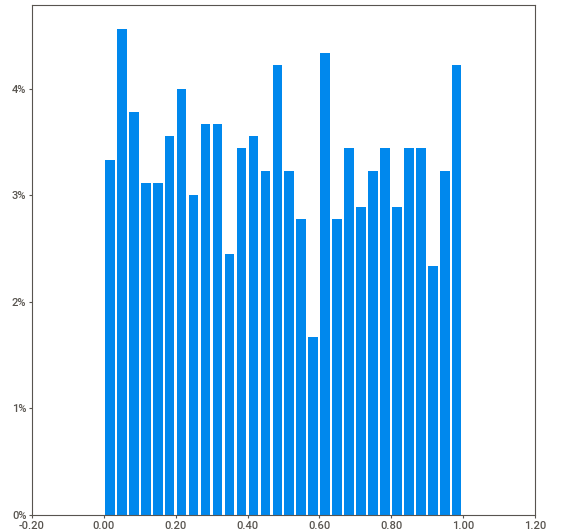
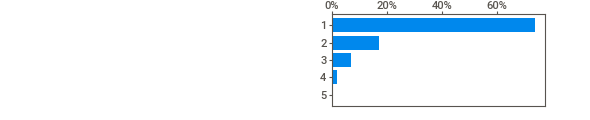
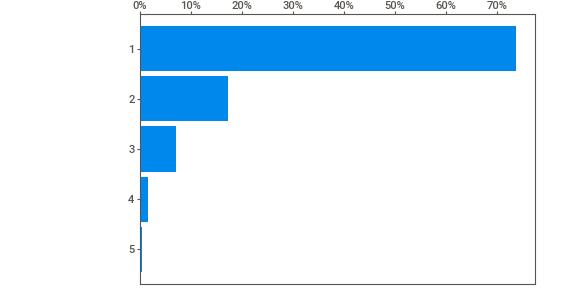
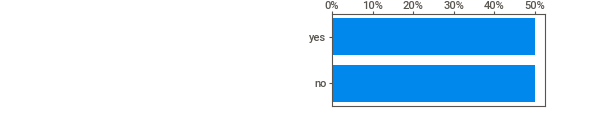
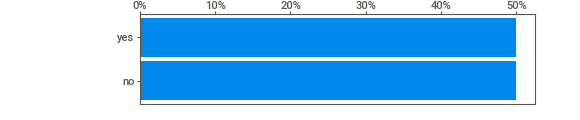
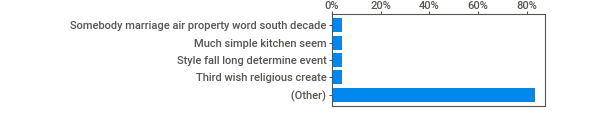
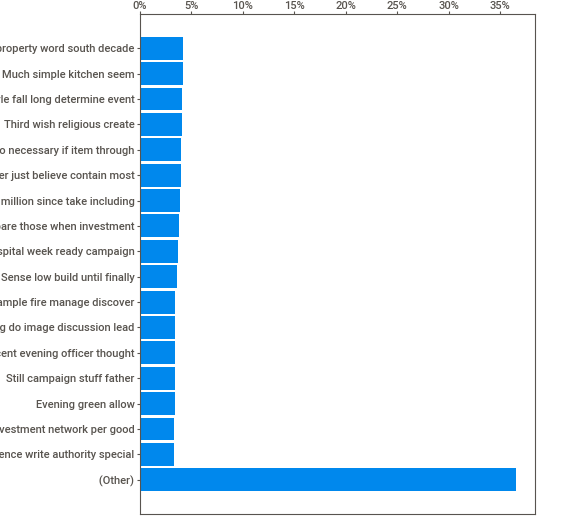
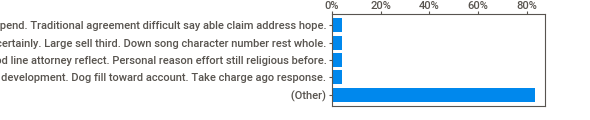
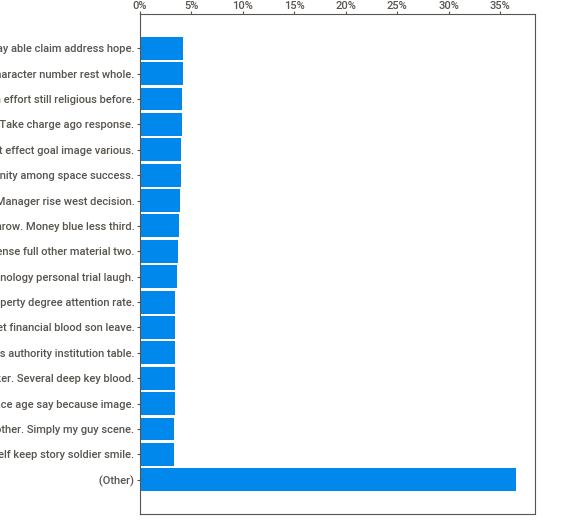
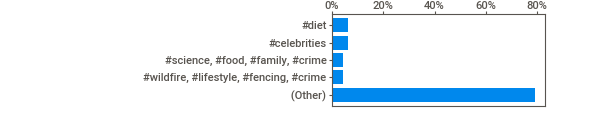
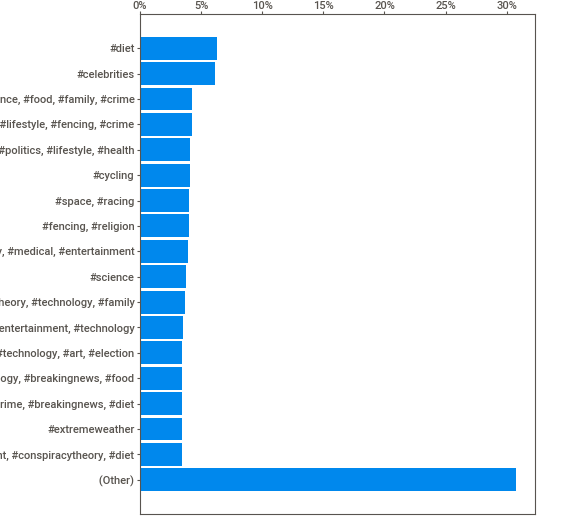
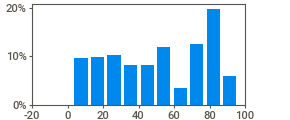
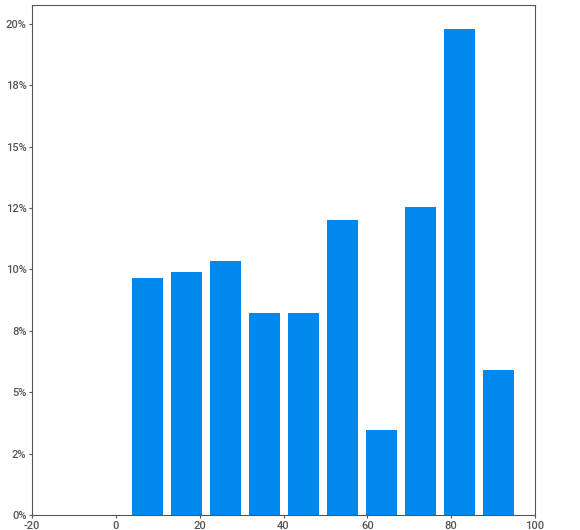
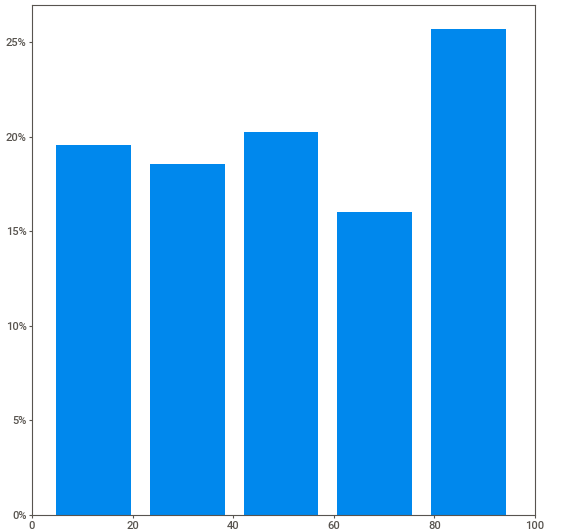
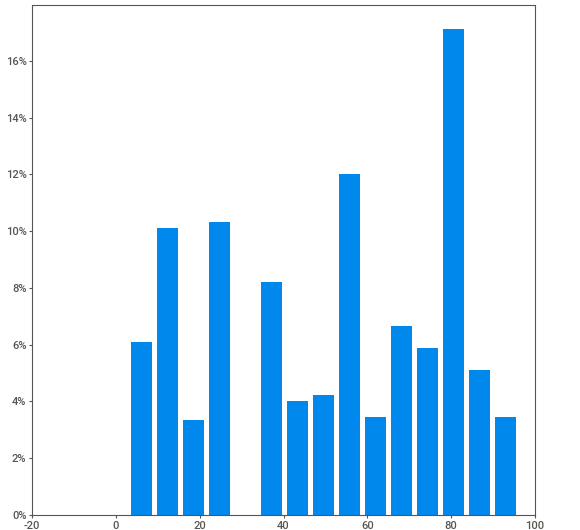
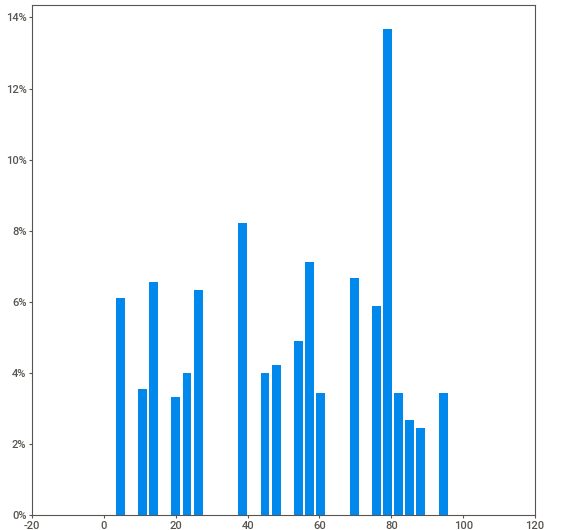
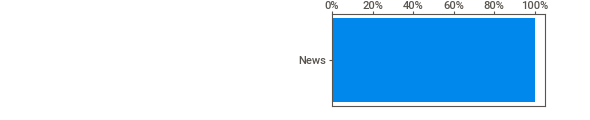
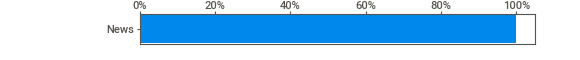
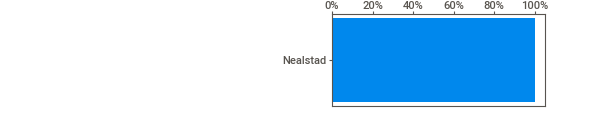
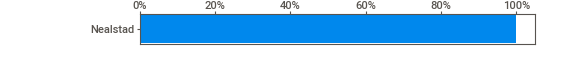
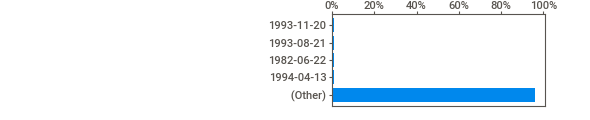
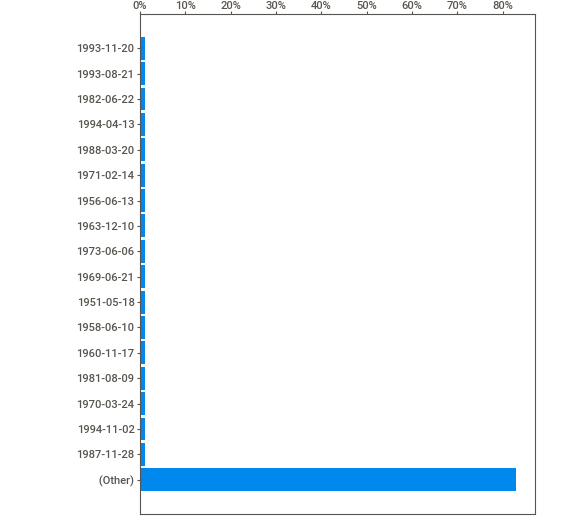
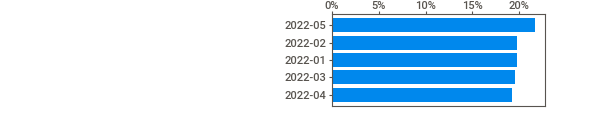
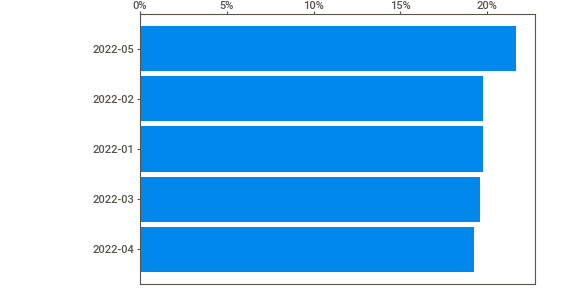
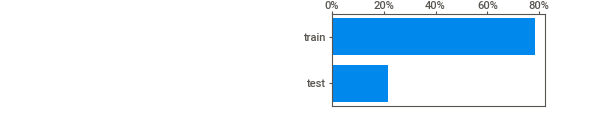
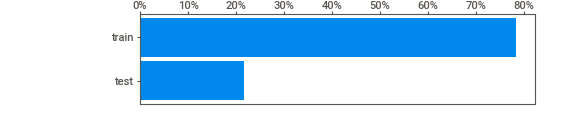
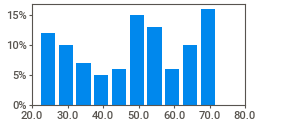
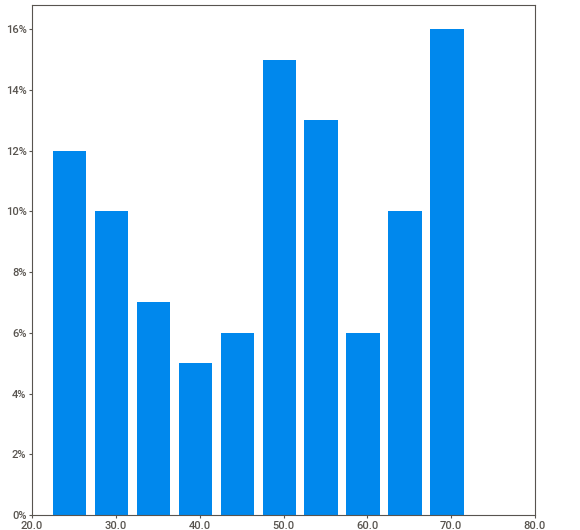
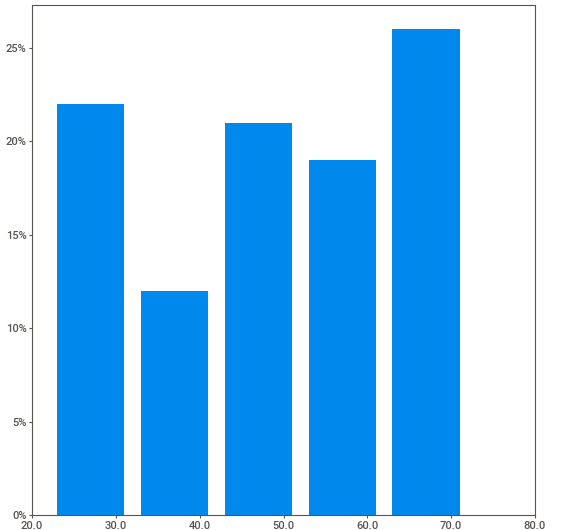
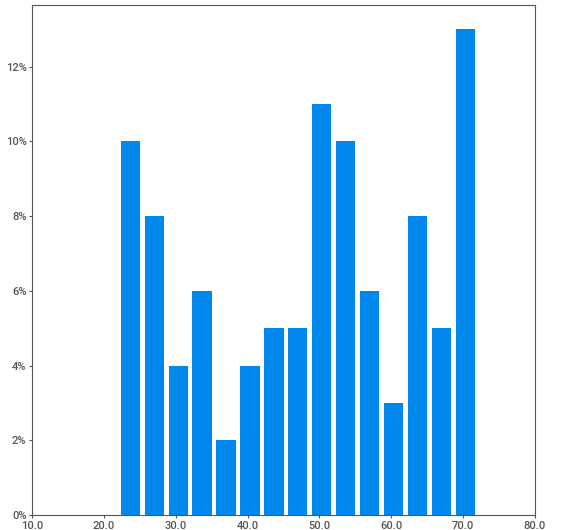
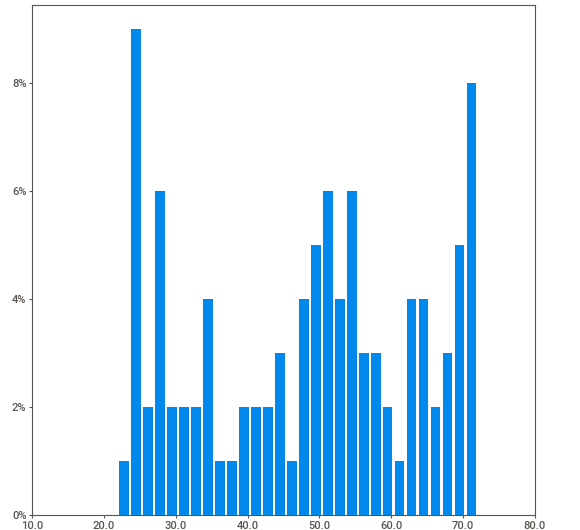
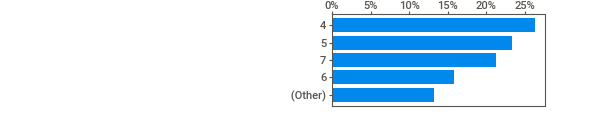
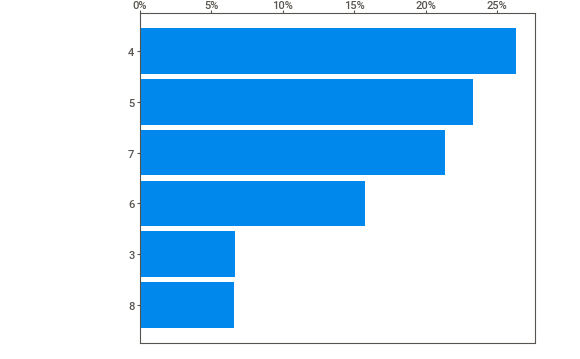
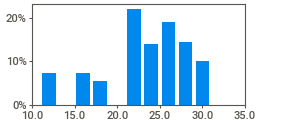
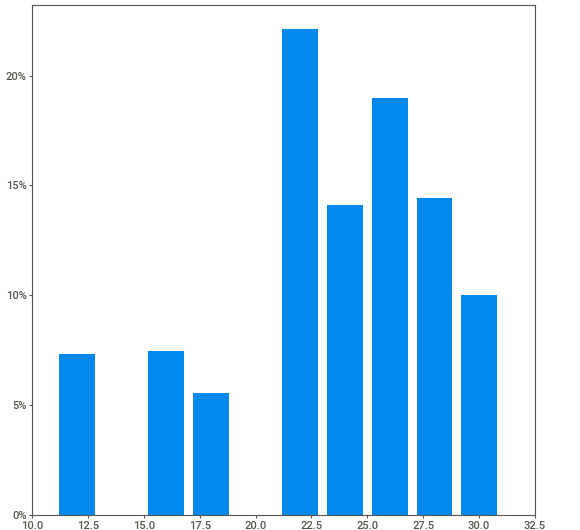
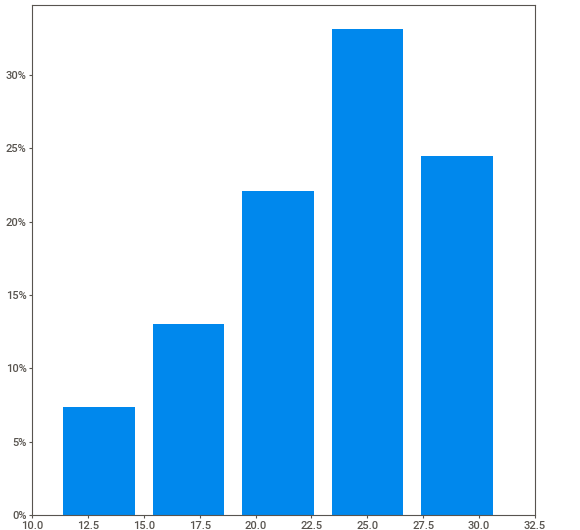
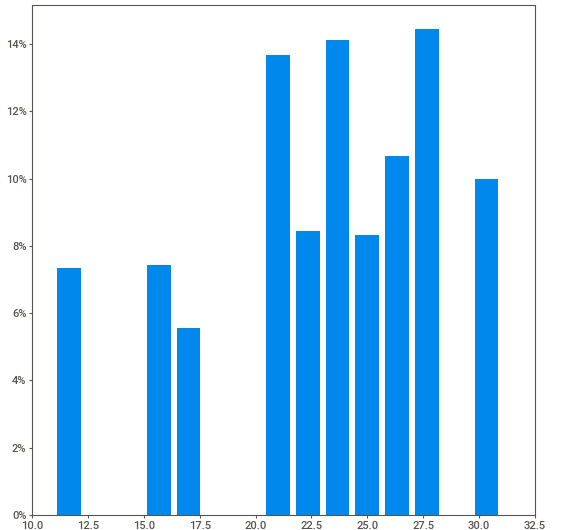
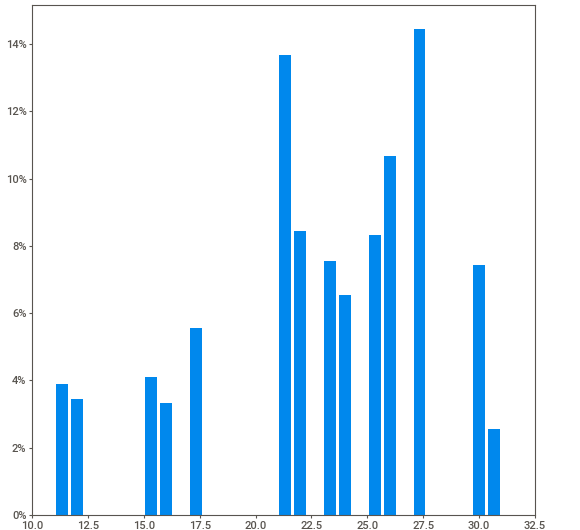
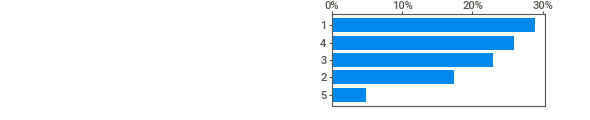
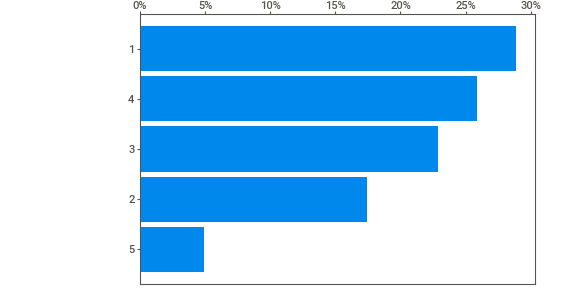
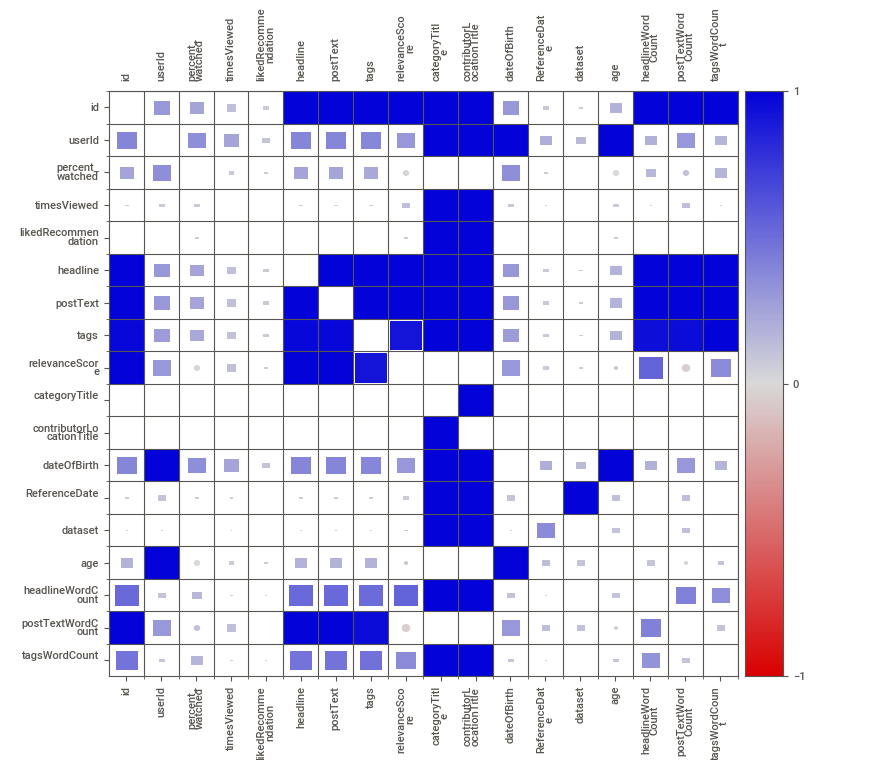
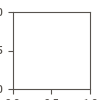

In [28]:
analysis = sv.analyze(dataprep_df)
analysis.show_notebook()

## 4.2 Classify the types of variables
#### list all columns to select the ones to be used

In [29]:
for i in dataprep_df.columns:
    print(i + ": " + analysis.get_type(i).name)

id: TYPE_CAT
userId: TYPE_CAT
percent_watched: TYPE_NUM
timesViewed: TYPE_CAT
likedRecommendation: TYPE_BOOL
headline: TYPE_CAT
postText: TYPE_CAT
tags: TYPE_CAT
relevanceScore: TYPE_NUM
categoryTitle: TYPE_CAT
contributorLocationTitle: TYPE_CAT
dateOfBirth: TYPE_CAT
ReferenceDate: TYPE_CAT
dataset: TYPE_CAT
age: TYPE_NUM
headlineWordCount: TYPE_CAT
postTextWordCount: TYPE_NUM
tagsWordCount: TYPE_CAT


### From the variables listed above you can select which  one will be tested in the model and confirm if the correct type is numeric(NUM) or categorical (CAT). Paste the correct information below:

In [30]:
#It is necessary to define the types of variables (cageroric and numeric) to ensure that the type of data used in the modeling will be the most suitable.
#For example, categorical variables need to be defined as a string because this prevents it from being treated as a numeric variable in H20 modeling
#Another example is that the string variables will have a missing treatment by placing the missing category for all values found as 'null'
CAT = []

#float
NUM = ['relevanceScore'
       ,'age'
       ,'headlineWordCount'
       ,'postTextWordCount'
       ,'tagsWordCount']
selected_features = CAT + NUM

In [31]:
#Numeric features must be float type
for col_name in NUM:
    dataprep_df[col_name] = dataprep_df[col_name].astype(float)

#Categorical features must be string
for col_name in CAT:
    dataprep_df[col_name] = dataprep_df[col_name].astype(str)

## 4.2 Outlier Analysys with Box plot and Violin Plot

In [32]:
def plot_comparison(x, title):
    fig, ax = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(15,5))
    fig.suptitle(title, fontsize=16)
    sns.distplot(x.rename(""), ax=ax[0])
    ax[0].set_title('Histogram + KDE')
    sns.boxplot(x.rename(""), ax=ax[1])
    ax[1].set_title('Boxplot')
    sns.violinplot(x.rename(""), ax=ax[2])
    ax[2].set_title('Violin plot')
    plt.show()

relevanceScore


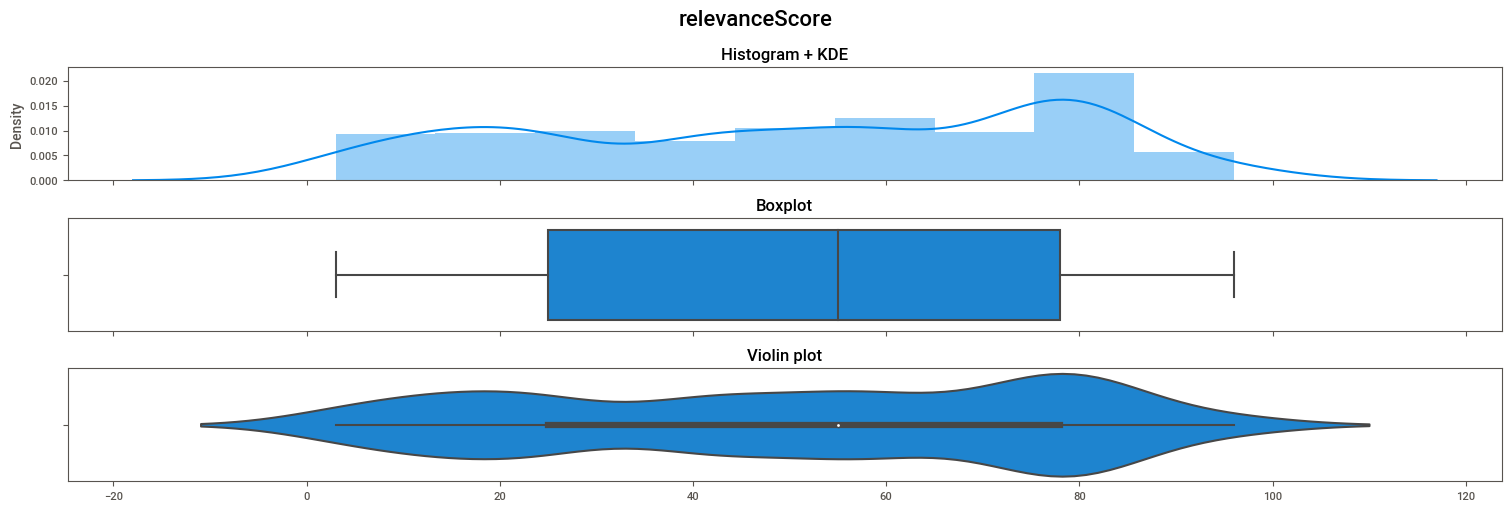

age


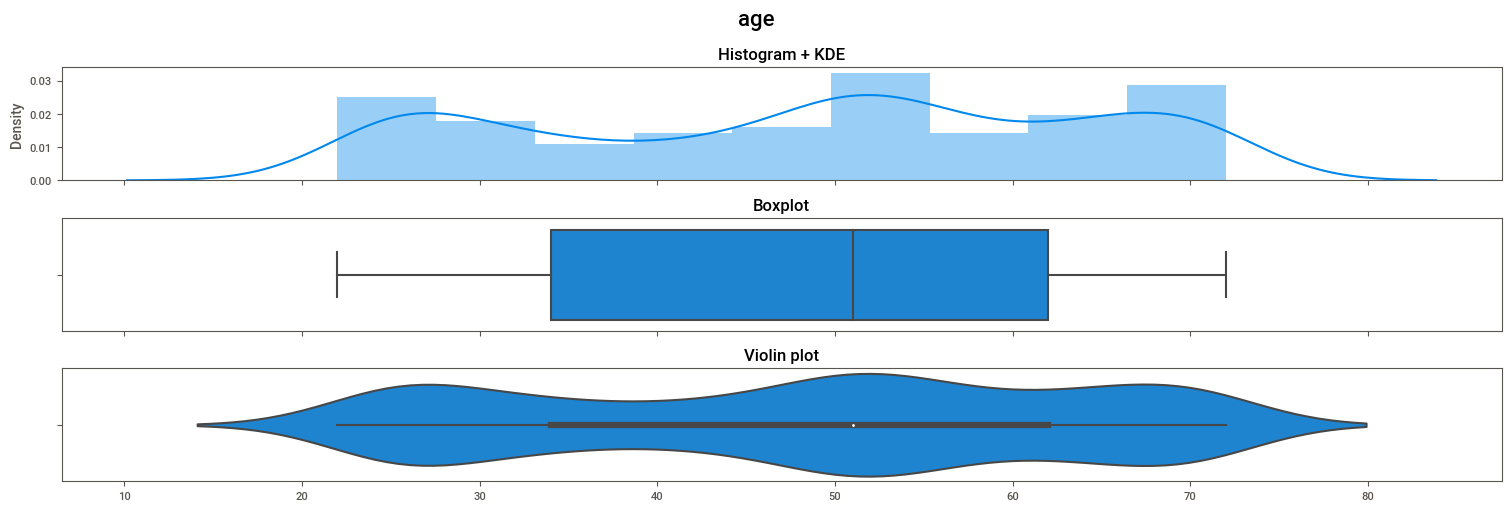

headlineWordCount


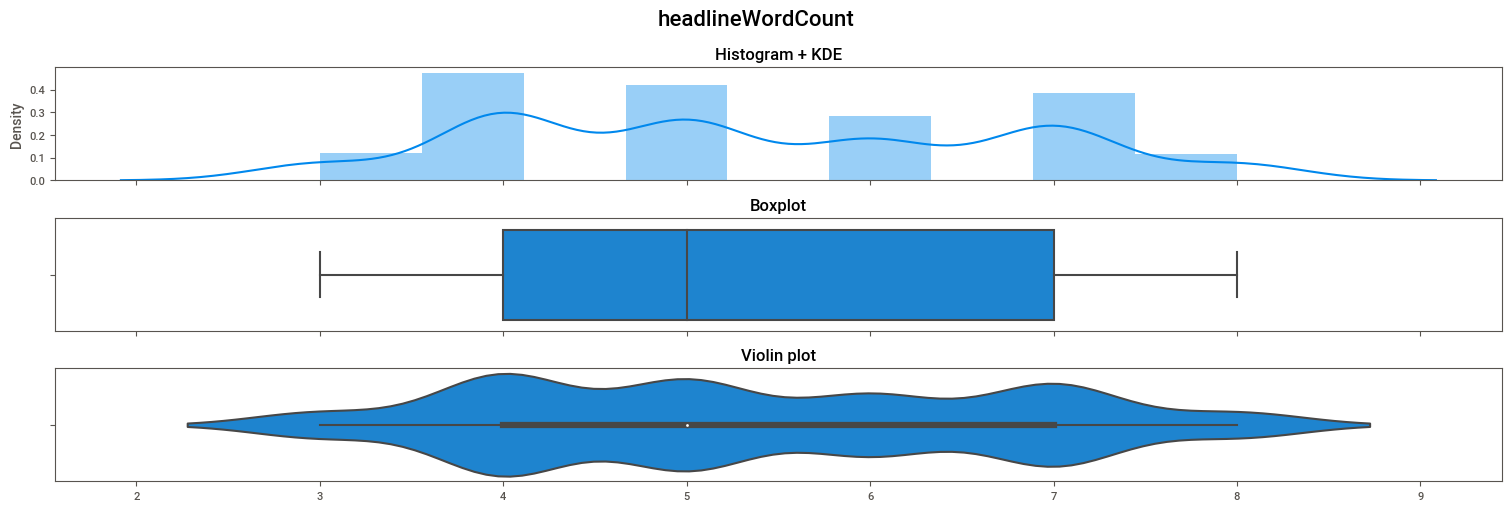

postTextWordCount


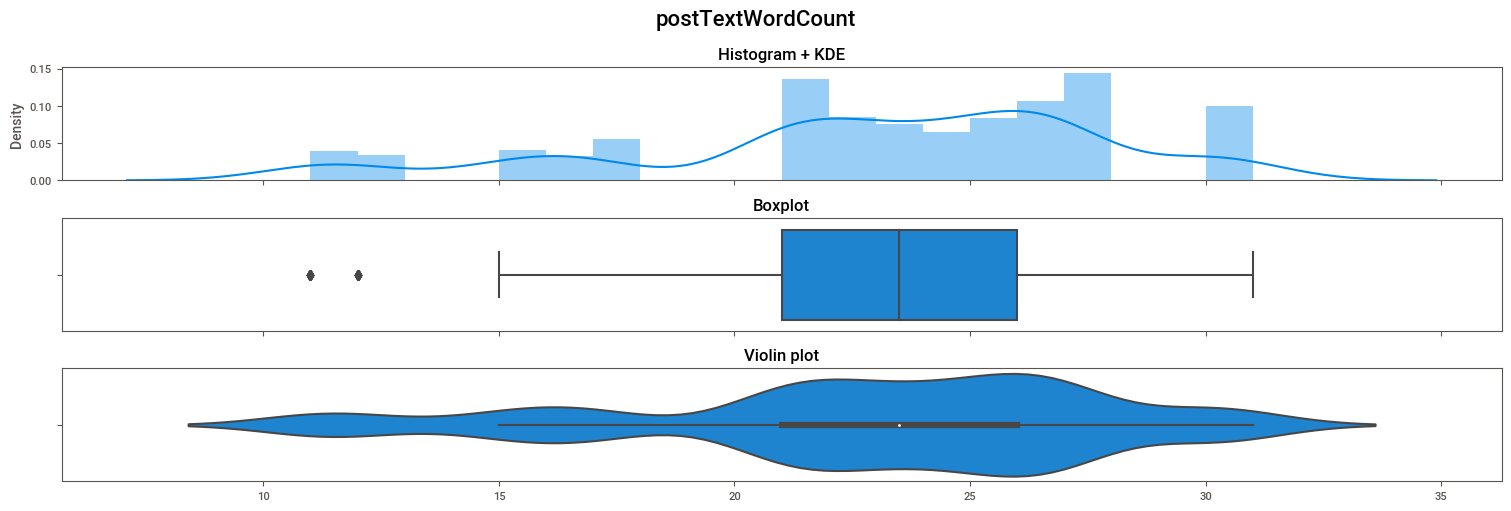

tagsWordCount


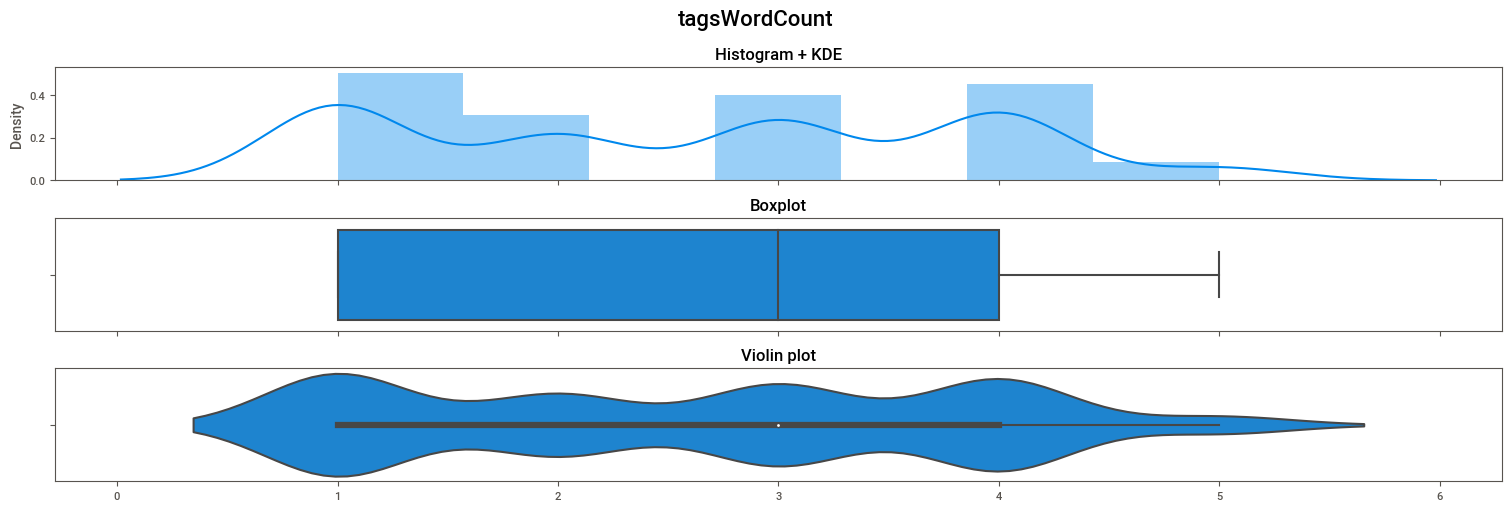

In [33]:
## Distribution analysis of numerical variables
for i in NUM:
    print(i)
    plot_comparison(dataprep_df[i], i)

## 4.3 Outliers Removing

In [34]:
# var = 'Fare'

# q_low = dataprep_df[var].quantile(0)
# q_hi  = dataprep_df[var].quantile(0.997)
# print('Low: ' + str(q_low))
# print('High: ' + str(q_hi))
# print('Reduction: ' 
#       + "{0:.2%}".format(len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])/len(dataprep_df)-1) 
#       + " | " 
#       + str(len(dataprep_df)-len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])))

# def plot_comparison(x, title, low, high):
#     fig, ax = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(15,5))
#     fig.suptitle(title, fontsize=16)
#     sns.distplot(x.rename(""), ax=ax[0])
#     ax[0].set_title('Histogram + KDE')
#     sns.boxplot(x.rename(""), ax=ax[1])
#     ax[1].set_title('Boxplot')
#     sns.violinplot(x.rename(""), ax=ax[2])
#     ax[2].set_title('Violin plot')
#     # only one line may be specified; full height
#     ax[1].axvline(x = low, color = 'red')
#     ax[1].axvline(x = high, color = 'red')
#     plt.show()
    
# plot_comparison(dataprep_df[var], var, q_low, q_hi)

# # dataprep_df = dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)]

# 5. Save final dataset with the selected features into S3 to train the model

In [36]:
csv_buffer = StringIO()
dataprep_df.query('dataset == "train"').loc[:, (selected_features+[VarId, VarDate])].to_csv(csv_buffer, index=False, header=True)
s3_resource = my_boto3_session.resource('s3')
s3_resource.Object(bucket, 'databases/%s/train_data/train_data.csv' % ModelName).put(Body=csv_buffer.getvalue())
del csv_buffer

csv_buffer = StringIO()
dataprep_df.query('dataset == "test"').loc[:, (selected_features+[VarId, VarDate])].to_csv(csv_buffer, index=False, header=True)
s3_resource = my_boto3_session.resource('s3')
s3_resource.Object(bucket, 'databases/%s/test_data/test_data.csv' % ModelName).put(Body=csv_buffer.getvalue())
del csv_buffer

In [37]:
#Include Glue delete table before start the crawler
glue = my_boto3_session.client('glue', region_name="us-east-1")

try:
    glue.create_crawler(
          Name='nowapp',
          Role= get_execution_role(),
          DatabaseName='nowapp',
          Description='nowapp',
         Targets={'S3Targets': [{'Path': 's3://%s/databases/%s' % (bucket, ModelName),
                                   'Exclusions': []}]})
except:
    print("OK: The crawler already exists. No need to recreate")
    
try:
    glue.delete_table(
        DatabaseName='nowapp',
        Name=ModelName
    )
except:
    print("OK: The table doesn't exist yet. It is not necessary to delete it.")

glue.update_crawler(Name='nowapp',
                    Targets={'S3Targets': [{'Path': 's3://%s/databases/%s' % (bucket, ModelName),
                               'Exclusions': []}]})

glue.start_crawler(Name='nowapp')

OK: O crawler já existe. Não é necessário recriar
OK: A tabela ainda não existe. Não é necessário apagá-la


{'ResponseMetadata': {'RequestId': '785c5f80-b3fd-4cbe-b716-87be7d33962d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Wed, 16 Nov 2022 20:20:22 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'connection': 'keep-alive',
   'x-amzn-requestid': '785c5f80-b3fd-4cbe-b716-87be7d33962d'},
  'RetryAttempts': 0}}

### Attention: If you get the error "An error occurred (InvalidInputException) when calling the CreateCrawler operation". Follow the steps:
1. Open Identity and Access Management (IAM)
2. Click on Roles
3. Open the Role name AmazonSageMaker-ExecutionRole-
4. Click on Add permissin > Attach Polices
5. Look for AWSGlueConsoleFullAccess
6. Select the policy and click Attach Polices
7. Repeat the same process for Policies AdministratorAccess and AmazonSageMakerServiceCatalogProductsGlueServiceRolePolicy
8. In the Trusted relationships tab, in Trusted entities paste the policy:<p>
{<p>
    "Version": "2012-10-17",<p>
    "Statement": [<p>
        {<p>
            "Effect": "Allow",<p>
            "Principal": {<p>
                "Service": "sagemaker.amazonaws.com"<p>
            },<p>
            "Action": "sts:AssumeRole"<p>
        },<p>
        {<p>
            "Effect": "Allow",<p>
            "Principal": {<p>
                "Service": "glue.amazonaws.com"<p>
            },<p>
            "Action": "sts:AssumeRole"<p>
        }<p>
    ]<p>
}
9. Run the code again